## Code Generation using RAG (Retrieval-Augmented Generation) Project

1- Dataset Preparation

In [34]:
import pandas as pd

# Load and process the HumanEval dataset.
# Extract task_id, prompt, and canonical_solution fields.
df = pd.read_parquet("hf://datasets/openai/openai_humaneval/openai_humaneval/test-00000-of-00001.parquet")[['task_id','prompt', 'canonical_solution']]

In [35]:
# Examine data
df.head()


,task_id,prompt,canonical_solution
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,return number % 1.0\n
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,balance = 0\n\n for op in operations:\n...
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean = sum(numbers) / len(numbers)\n re...


In [36]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   task_id             164 non-null    object
 1   prompt              164 non-null    object
 2   canonical_solution  164 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB
None


2- Embedding Pipeline

In [37]:
# Use an open-source LLM to embed the prompt fields using BAAI/bge-large-en-v1.5
# BAAI/bge-large-en-v1.5 is state of the art in english test embedding
from sentence_transformers import SentenceTransformer   

embedding_model = SentenceTransformer("BAAI/bge-large-en-v1.5").to('cuda')

embeddings = embedding_model.encode(
    df["prompt"].tolist(),
    batch_size=32,                          # You can tune this (e.g., 16/64 depending on GPU memory)
    show_progress_bar=True,                # Optional, shows a progress bar
    normalize_embeddings=True,
    device='cuda'                          # Forces encoding on GPU
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


In [38]:
# Create a collection to store documents and embeddings using Chroma DB
# Chroma DB is the best for small to mid-scale RAG
import chromadb

collection = chromadb.Client().create_collection(name="my_rag_collection")

InternalError: Collection [my_rag_collection] already exists

In [ ]:
metadata = df[["prompt", "canonical_solution"]].to_dict("records")

collection.add(
    ids = df["task_id"].astype(str).tolist(),
    # documents = df["prompt"].tolist(),
    metadatas = metadata,
    embeddings = embeddings
)

3- Retrieval Engine

In [ ]:
def retrieve_nearest(query,k):
    query_embedded = embedding_model.encode([query], normalize_embeddings=True, device='cuda')
    result = collection.query(
        query_embeddings=query_embedded,
        n_results=k
    )
    return {
        "ids": result["ids"][0],
        "metadatas" : result["metadatas"][0],
    } # Return the 'k' ids and solutions in a list format

In [ ]:
# Test Retrieval Engine
results = retrieve_nearest(df["prompt"][0],3)
# print (results["metadatas"][0]["prompt"])
for id in results["ids"]:
    print(f'{id}')


4- Code Generator using deepseek-chat-v3 from openrouter.ai

In [ ]:
# Use an open-source code generation model with coding knowledge to generate Python code using the prompt and retrieved code snippets as context.
import requests

key = "OPENROUTER_API_KEY"

def generate_code(query, retrieved_chunks):
    API_URL = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {key}", 
        "Content-Type": "application/json"
    }

    # Combine retrieved chunks into a single string
    # context = "\n\n".join(retrieved_chunks["prompt"])
    
    context = ""
    for entry in retrieved_chunks["metadatas"]:
        context = context + "\n\n[Prompt]\n" + entry["prompt"] + "\n[Solution\n" + entry["canonical_solution"]
    # Format RAG-style prompt
    prompt = f"""You are a helpful coding assistant.

Respond only with python code with no description or additional text.
Use the following retrieved context to answer the user's question.
The Context consists of a prompt and an answer

[Context]
{context}

[User Question]
{query}
"""

    data = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.2,
        "max_tokens": 500  
    }

    # response = requests.post(API_URL, headers=headers, json=data)
    count = 0
    while(True):
        try:
            count+=1
            response = requests.post(API_URL, headers=headers, json=data)
            return response.json()["choices"][0]["message"]["content"]
        except:
            if(count==5):
                break
            print(response.json())


In [ ]:
# Test Code generator
query = df["prompt"][0]
context = retrieve_nearest(query,3)
result = generate_code(query,context)
print(result)

5- Integration

In [ ]:
# Combine embedding, retrieval, and generation into a clean modular pipeline.
# Accept a prompt ➝ retrieve similar examples ➝ generate and return new code.

def RAG_pipeline(k_examples,user_input = False,prompt=""):
    if(user_input == True):
        query = input("Please Enter your query")        # Accept a prompt
    else:
        query = prompt
    context = retrieve_nearest(query,k_examples)        # Retrieve similar examples
    result = generate_code(query,context)                 # Generate and return new code.
    return result

In [ ]:
print(df["prompt"][0])

In [ ]:
# Test Integration pipeline
result = RAG_pipeline(3,True)
print(result)

6- Evaluate Performance using BERTScore

In [ ]:
# Testing data

data = [
    {
        "prompt": '''def is_palindrome_number(n: int) -> bool:
    """
    Return True if the integer n is a palindrome number (reads the same forward and backward).
    A negative number is not considered a palindrome.
    """''',
        "canonical_solution": '''def is_palindrome_number(n: int) -> bool:
    if n < 0:
        return False
    return str(n) == str(n)[::-1]'''
    },
    {
        "prompt": '''def count_substring(s: str, sub: str) -> int:
    """
    Return the number of non-overlapping occurrences of substring sub in string s.
    """''',
        "canonical_solution": '''def count_substring(s: str, sub: str) -> int:
    return s.count(sub)'''
    },
    {
        "prompt": '''def filter_non_negative(numbers: List[float]) -> List[float]:
    """
    Given a list of numbers, return a new list containing only the non-negative values.
    """''',
        "canonical_solution": '''def filter_non_negative(numbers: List[float]) -> List[float]:
    return [x for x in numbers if x >= 0]'''
    },
    {
        "prompt": '''def average_word_length(text: str) -> float:
    """
    Return the average word length in the input string.
    Words are separated by spaces. If there are no words, return 0.0.
    """''',
        "canonical_solution": '''def average_word_length(text: str) -> float:
    words = text.split()
    if not words:
        return 0.0
    return sum(len(word) for word in words) / len(words)'''
    },
    {
        "prompt": '''def unique_sorted(items: List[int]) -> List[int]:
    """
    Return a sorted list of unique integers from the input list.
    """''',
        "canonical_solution": '''def unique_sorted(items: List[int]) -> List[int]:
    return sorted(set(items))'''
    }
]

test_df = pd.DataFrame(data)

In [39]:
from evaluate import load
bert_score = load("bertscore")

for example in range(len(test_df["prompt"])):
    prediction = RAG_pipeline(3,False,test_df["prompt"][example])
    evaluation = bert_score.compute(predictions=[result], references=[test_df["canonical_solution"][example]], lang="en",device="cuda")
    print(f"F1 score for example {example+1} = {evaluation['f1'][0]*100:.02f} %")

NameError: name 'test_df' is not defined

Prepare for LangGraph

In [ ]:
# Define a function to explain code
def explain_code(code):
    API_URL = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {key}",
        "Content-Type": "application/json"
    }
    
    prompt = f"""You are a helpful coding explination assistant.

Explain the following code with no any additional text.


[Code]
{code}

"""

    data = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.2,
        "max_tokens": 500  
    }

    count = 0
    while(True):
        try:
            count+=1
            response = requests.post(API_URL, headers=headers, json=data)
            return response.json()["choices"][0]["message"]["content"]
        except:
            if(count==5):
                break
            print(response.json())

    

In [ ]:
# Define a function to resume the same task
def resume_code(history):
    API_URL = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {key}",
        "Content-Type": "application/json"
    }
    
    prompt = f"""You are a helpful coding assistant.
    Use the provided chat history to continue helping the user based on the last human messages given

Explain the following code with no any additional text.


[Chat History]
{history}

"""

    data = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.2,
        "max_tokens": 500  
    }

    
    count = 0
    while(True):
        try:
            count+=1
            response = requests.post(API_URL, headers=headers, json=data)
            return response.json()["choices"][0]["message"]["content"]
        except:
            if(count==5):
                break
            print(response.json())

    

In [ ]:
# Define a function to explain code depending on history 
def explain_code_with_history(history):
    API_URL = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {key}",
        "Content-Type": "application/json"
    }
    
    prompt = f"""You are a helpful coding explination assistant.
Provided chat history for context and the last massage describes the needed task.
Explain the code with no any additional text.


[History]
{history}

"""

    data = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.2,
        "max_tokens": 500  
    }

    count = 0
    while(True):
        try:
            count+=1
            response = requests.post(API_URL, headers=headers, json=data)
            return response.json()["choices"][0]["message"]["content"]
        except:
            if(count==5):
                break
            print(response.json())

    

### LangGraph

First Structure - Basic

In [40]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

# Define graph state class
class modelState(TypedDict):
    input : str
    func : str
    result : str

# Define graph runnables
def chat(state: modelState) -> modelState:
    """Function to take input from user"""
    
    # # Input from user
    # state["func"] = input("Please state whether you want to generate code or explain your code")
    
    # if("explain" in state["func"]):
    #     state["input"] = input("Please enter the code you want its description")
    # elif("generate" in state["func"]):
    #     state["input"] = input("Please enter the code description")
    
    # Input from code
    
    return state

def router(state: modelState) -> modelState:
    """Function to select the next node of the graph"""
    if("explain" in state["func"]):
        return "explain_task"
    elif("generate" in state["func"]):
        return "generate_task"
        
def generate(state: modelState) -> modelState:
    """Function to generate code based on input from user using RAG model"""
    state["result"]  = RAG_pipeline(3,False,state["input"])
    return state

def explain(state: modelState) -> modelState:
    """Function to explain code provided by the user using LLM model"""
    state["result"]  = explain_code(state["input"])
    return state
    
# Define graph object
graph = StateGraph(modelState)

# Define graph nodes
graph.add_node("chat",chat)
graph.add_node("generate_code",generate)
graph.add_node("explain_code",explain)
graph.add_node("router", lambda state:state)

# Define graph edges
graph.add_edge(START,"chat")
graph.add_edge("chat","router")

graph.add_conditional_edges(
    "router",
    router, 
    {
        # Edge: Node
        "explain_task": "explain_code",
        "generate_task": "generate_code"
    }
)

graph.add_edge("generate_code",END)
graph.add_edge("explain_code",END)

app = graph.compile()

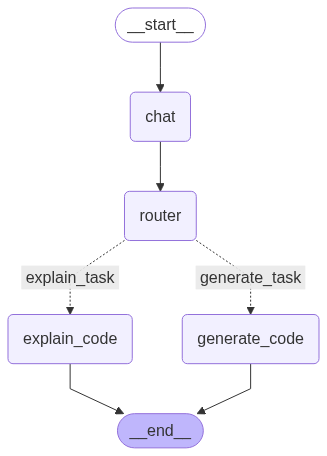

In [41]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png())) # Display structure

In [42]:
# Test using custom input
custom_input= modelState(input=test_df["prompt"][0],func="I want to generate code")

# output = app.invoke({})
output = app.invoke(custom_input)
print(output["result"])

NameError: name 'test_df' is not defined

Second Structure - Using tools with manual invoke

In [43]:
from langchain_core.tools import tool

# Define graph state class
class modelState2(TypedDict):
    input : str
    func : str
    result : str

@tool
def generator_tool(query: str)->str:
    """ This tool generates code using an input query """
    return RAG_pipeline(3,False,query)

@tool
def explainer_tool(code: str)->str:
    """ This tool explains code given by the user """
    return explain_code(code)

# Define graph runnables
def chat2(state: modelState2) -> modelState2:
    """Function to take input from user"""
    
    # # Input from user
    # state["func"] = input("Please state whether you want to generate code or explain your code")
    
    # if("explain" in state["func"]):
    #     state["input"] = input("Please enter the code you want its description")
    #     state["result"] = explainer_tool.invoke({"code" : state["input"]})
    # elif("generate" in state["func"]):
    #     state["input"] = input("Please enter the code description")
    #     state["result"] = generator_tool.invoke({"query" : state["input"]})
    
    # Input from code
    if("explain" in state["func"]):
        state["result"] = explainer_tool.invoke({"code" : state["input"]})
    elif("generate" in state["func"]):
        state["result"] = generator_tool.invoke({"query" : state["input"]})
    return state
    
# Define graph object
graph2 = StateGraph(modelState2)

# Define graph nodes
graph2.add_node("chat",chat2)

# Define graph edges
graph2.add_edge(START,"chat")

graph2.add_edge("chat",END)

app2 = graph2.compile()

In [ ]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [ ]:
output2 = app2.invoke(custom_input)
print(output2["result"])

Third Structure - Using tools with automatic invoke

In [ ]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage

# Define graph state class
class modelState3(TypedDict):
    input : str
    func : str
    result : str

@tool
def generator_tool3(query: str)->str:
    """ This tool generates code using an input query """
    return RAG_pipeline(3,False,query)

@tool
def explainer_tool3(code: str)->str:
    """ This tool explains code given by the user """
    return explain_code(code)

tools = [generator_tool3,explainer_tool3]

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    api_key="API_KEY"
).bind_tools(tools)

# Define graph runnables
def chat3(state: modelState3) -> modelState3:
    """Function to take input from user"""
    
    # # Input from user
    # state["func"] = input("Please state whether you want to generate code or explain your code")
    
    # if("explain" in state["func"]):
    #     state["input"] = input("Please enter the code you want its description")
    # elif("generate" in state["func"]):
    #     state["input"] = input("Please enter the code description")
    
    # Input from code
    
    prompt = (f"""
    You are a code generator or code explainer.
    - 'generator_tool3' tool with the complete description provided to generate code.
    - 'explainer_tool3' tool with the complete code given to explain code.
    
    The current user prompt is:{state["input"]}
    """)
    response = llm.invoke(prompt)
    state["result"] = response.content
    print(f"\n🤖 AI: {response.content}")
# Define graph object
graph3 = StateGraph(modelState3)

# Define graph nodes
graph3.add_node("chat",chat3)

# Define graph edges
graph3.add_edge(START,"chat")

graph3.add_edge("chat",END)

app3 = graph3.compile()

In [ ]:
display(Image(app3.get_graph().draw_mermaid_png()))

In [ ]:
custom_input= modelState3(input=test_df["prompt"][0],func="I want to generate code")
app3.invoke(custom_input)

Fourth Structure - Using Resume node to handle extended tasks with history

In [45]:
from langchain_core.messages import HumanMessage, AIMessage
from typing import List, Union

# Define graph state class
class modelState(TypedDict):
    messages : List[Union[HumanMessage, AIMessage]]

# Define graph runnables
def chat(state: modelState) -> modelState:
    """Function to take input from user"""
    
    # # Input from user
    
    
    # state["func"] = input("Please state whether you want to generate code or explain your code")
    
    # if("explain" in state["func"]):
    #     input = input("Please enter the code you want its description")
    #     state["messages"].append(HumanMessage(content=input))
    # elif("generate" in state["func"]):
    #     input = input("Please enter the code description")
    #     state["messages"].append(HumanMessage(content=input))
    
    # Input from code
    
    return state

def router(state: modelState) -> modelState:
    """Function to select the next node of the graph"""
    if("explain" in state['messages'][-1].content):
        return "explain_task"
    elif("generate" in state['messages'][-1].content):
        return "generate_task"
    else:
        return "resume_task"
        
def generate(state: modelState) -> modelState:
    """Function to generate code based on input from user using RAG model"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state["messages"].append(AIMessage(content=RAG_pipeline(3,False,str(state['messages'][-1]))))
    print(f"\nAI: {state['messages'][-1].content}")
    return state

def explain(state: modelState) -> modelState:
    """Function to explain code provided by the user using LLM model"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state["messages"].append(AIMessage(content=explain_code_with_history(state['messages'])))
    print(f"\nAI: {state['messages'][-1].content}")
    return state

def resume(state: modelState) -> modelState:
    """Function to resume the same task provided by the user"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state['messages'].append(AIMessage(content=resume_code(state['messages'])))
    print(f"\nAI: {state['messages'][-1].content}")
    return state
# Define graph object
graph = StateGraph(modelState)

# Define graph nodes
graph.add_node("chat",chat)
graph.add_node("generate_code",generate)
graph.add_node("explain_code",explain)
graph.add_node("resume_code",resume)
graph.add_node("router", lambda state:state)

# Define graph edges
graph.add_edge(START,"chat")
graph.add_edge("chat","router")

graph.add_conditional_edges(
    "router",
    router, 
    {
        # Edge: Node
        "explain_task": "explain_code",
        "generate_task": "generate_code",
        "resume_task": "resume_code"
    }
)

graph.add_edge("generate_code",END)
graph.add_edge("explain_code",END)
graph.add_edge("resume_code",END)

app4 = graph.compile()

In [ ]:
display(Image(app4.get_graph().draw_mermaid_png()))

In [ ]:
conversation_history : List[Union[HumanMessage, AIMessage]] = []


user_input = test_df["prompt"][0] # Custom initial input
while user_input != "exit": # Maintain a loop that interacts with the user naturally
    conversation_history.append(HumanMessage(content=user_input))
    output = app4.invoke(modelState(messages=conversation_history))
    conversation_history = output["messages"]
    user_input = input("Enter: ")

# Save output in log file
with open("logging.text",'w') as file:
    file.write("Conversation Log:\n")
    for message in conversation_history:
        if isinstance(message,HumanMessage):
            file.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

Smart Routing

In [46]:
def smartRouter(history):
# Define a function to smart route the langGraph depending on history 
    API_URL = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {key}",
        "Content-Type": "application/json"
    }
    
# Provide just the task and user input in the following json format {'task : task,  user_input : user_input'}".
    # print("Router:")
    # print(history)
    hist = ""
    for i,message in enumerate(history):
        try:
            if(i%2==0):
                hist = hist + "Human: " + message.content + '\n'
            else:
                hist = hist + "AI: " + message.content + '\n'
        except:
             hist = hist + message + '\n'
            
            
    prompt = f"""
You are a smart router to decide the next task based on user prompt.
You are provided with conversation history, use the last Human message to identify the needed task and the history for context.

Your job is to classify the following user input as one of the following 3 tasks:
- **generate code**
- **explain code**
- **resume conversation**

Rules:
- If the user provides a **code description**, or a **partial/incomplete code** (e.g., missing function body, TODOs, comments like "please complete"), classify it as **generate code**.
- If the user provides a **complete piece of code** and is asking to understand or describe it, classify it as **explain code**.
- If the user does not ask a new question but refers to a **previous conversation**, classify it as **resume conversation**.

Respond only with one of the following **three exact outputs**:
generate code, explain code, or resume conversation.
### Examples:

[Prompt]
\"""Write a function that checks if a number is prime.\"""
→ generate code

[Prompt]
\"""def is_prime(n):\n    # complete this function\n    \"""
→ generate code

[Prompt]
\"""Can you explain how this sorting function works?\n\ndef bubble_sort(arr): ...\"""
→ explain code

[Prompt]
\"""Let's continue from the last thing we talked about regarding optimization.\"""
→ resume conversation

[Prompt]
\"""do something with things you wrote before.\"""
→ resume conversation

Now classify this:

[History]
{hist}

"""
    # print(prompt)

    data = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.2,
        "max_tokens": 500  
    }

    count = 0
    while(True):
        try:
            count+=1
            response = requests.post(API_URL, headers=headers, json=data)
            # print(response.json())
            return response.json()["choices"][0]["message"]["content"]
        except:
            if(count==5):
                break
            print(response.json())

    

In [47]:
prompt = """from typing import List

Complete this function

def has_close_elements(numbers: List[float], threshold: float) -> bool:
    "" Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    ""
"""
print(smartRouter(prompt))
print(smartRouter("modify the function you just wrote"))

generate code
resume conversation


In [48]:
from langchain_core.messages import HumanMessage, AIMessage
from typing import List, Union

# Define graph state class
class modelState(TypedDict):
    messages : List[Union[HumanMessage, AIMessage]]

# Define graph runnables
def chat(state: modelState) -> modelState:
    """Function to take input from user"""
    
    # # Input from user
    
    
    # state["func"] = input("Please state whether you want to generate code or explain your code")
    
    # if("explain" in state["func"]):
    #     input = input("Please enter the code you want its description")
    #     state["messages"].append(HumanMessage(content=input))
    # elif("generate" in state["func"]):
    #     input = input("Please enter the code description")
    #     state["messages"].append(HumanMessage(content=input))
    
    # Input from code
    
    return state

def smartrouter(state: modelState) -> modelState:
    """Function to select the next node of the graph"""
    # print("Graph:")
    # print(state["messages"])
    result = smartRouter(state["messages"])
    # print(state)
    # print(f"Task needed: {result}")
    if result == "explain code":
        return "explain_code"
    elif result == "generate code":
        return "generate_code"
    elif result == "resume conversation":
        return "resume_code"
    
        
def generate(state: modelState) -> modelState:
    """Function to generate code based on input from user using RAG model"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state["messages"].append(AIMessage(content=RAG_pipeline(3,False,str(state['messages'][-1]))))
    print(f"\nAI: {state['messages'][-1].content}")
    # print("generate")
    return state

def explain(state: modelState) -> modelState:
    """Function to explain code provided by the user using LLM model"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state["messages"].append(AIMessage(content=explain_code_with_history(state['messages'])))
    print(f"\nAI: {state['messages'][-1].content}")
    # print("explain")
    return state

def resume(state: modelState) -> modelState:
    """Function to resume the same task provided by the user"""
    print(f"\nHuman: {state['messages'][-1].content}")
    state['messages'].append(AIMessage(content=resume_code(state['messages'])))
    print(f"\nAI: {state['messages'][-1].content}")
    # print("resume")
    return state
# Define graph object
graph = StateGraph(modelState)

# Define graph nodes
graph.add_node("chat",chat)
graph.add_node("generate_code",generate)
graph.add_node("explain_code",explain)
graph.add_node("resume_code",resume)
graph.add_node("router", lambda state: state)

# Define graph edges
graph.add_edge(START,"chat")
graph.add_edge("chat", "router")

graph.add_conditional_edges(
    "router", 
    smartrouter, 
{
    "explain_code": "explain_code",
    "generate_code": "generate_code",
    "resume_code": "resume_code"
})

graph.add_edge("generate_code",END)
graph.add_edge("explain_code",END)
graph.add_edge("resume_code",END)

app5 = graph.compile()

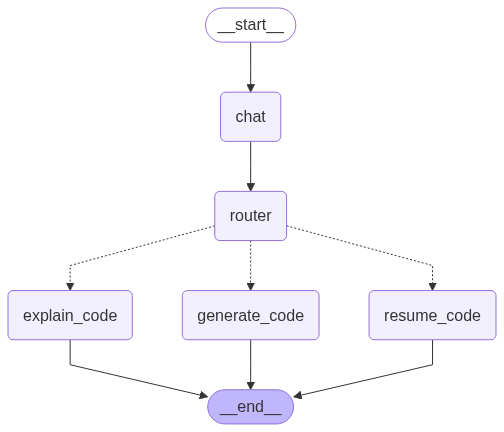

In [49]:
display(Image(app5.get_graph().draw_mermaid_png()))

In [ ]:
conversation_history : List[Union[HumanMessage, AIMessage]] = []


user_input = test_df["prompt"][0] # Custom initial input
while user_input != "exit": # Maintain a loop that interacts with the user naturally
    conversation_history.append(HumanMessage(content=user_input))
    output = app5.invoke(modelState(messages=conversation_history))
    conversation_history = output["messages"]
    user_input = input("Enter: ")

# Save output in log file
with open("logging.text",'w') as file:
    file.write("Conversation Log:\n")
    for message in conversation_history:
        if isinstance(message,HumanMessage):
            file.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

Deployment with Gradio

In [ ]:
import gradio as gr

langchain_history = []

def respond(message, chat_history):
    
    # Append latest user message
    langchain_history.append(HumanMessage(content=message))

    # Prepare input for LangGraph
    state_input = modelState(messages = langchain_history)

    # Invoke LangGraph app
    result = app5.invoke(state_input)

    # Get latest AI message
    response = result["messages"][-1].content

    # Add to Gradio-friendly chat history
    chat_history.append((message, response))

    return "", chat_history

with gr.Blocks() as interface:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")

    state = gr.State([])

    msg.submit(respond, [msg, state], [msg, chatbot])
    clear.click(lambda: None, None, chatbot)

interface.launch()


C:\Users\Dell\AppData\Local\Temp\ipykernel_9324\2708235937.py:26: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


{'error': {'message': 'Provider returned error', 'code': 524, 'metadata': {'raw': 'error code: 524', 'provider_name': 'Targon'}}, 'user_id': 'user_30CBUFyjisNwIyE97GpqwEuu3jU'}

Human: generate a function that prints even numbers only


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



AI: ```python
def print_even_numbers(numbers):
    for num in numbers:
        if num % 2 == 0:
            print(num)
```

Human: in the function you wrote, print omar at its end

AI: ```python
def print_even_numbers(numbers):
    for num in numbers:
        if num % 2 == 0:
            print(num)
    print("omar")
```


RAG Evaluation on MBPP Examples

In [ ]:
# Use the [MBPP dataset](10 examples)
# Each has: `task_id`, `prompt`, `code_solution`, and test cases.

mbpp_df = pd.read_json("mbpp.jsonl", lines=True)[0:10][["task_id","text","code","test_list"]]

print(mbpp_df.head())

   task_id                                               text  \
0        1  Write a function to find the minimum cost path...   
1        2  Write a function to find the similar elements ...   
2        3  Write a python function to identify non-prime ...   
3        4  Write a function to find the largest integers ...   
4        5  Write a function to find the number of ways to...   

                                                code  \
0  R = 3\r\nC = 3\r\ndef min_cost(cost, m, n): \r...   
1  def similar_elements(test_tup1, test_tup2):\r\...   
2  import math\r\ndef is_not_prime(n):\r\n    res...   
3  import heapq as hq\r\ndef heap_queue_largest(n...   
4  def count_ways(n): \r\n\tA = [0] * (n + 1) \r\...   

                                           test_list  
0  [assert min_cost([[1, 2, 3], [4, 8, 2], [1, 5,...  
1  [assert similar_elements((3, 4, 5, 6),(5, 7, 4...  
2  [assert is_not_prime(2) == False, assert is_no...  
3  [assert heap_queue_largest( [25, 35, 22, 85, 1...

In [ ]:
# For each prompt:
# - Retrieve similar examples using embedding similarity
# - Feed to the LLM for completion (RAG style).

solutions = []
for p in mbpp_df["text"].tolist():
    r = RAG_pipeline(3,False,p)
    solutions.append(r)

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'error': {'message': 'Internal Server Error', 'code': 500}}
{'error': {'message': 'Provider returned error', 'code': 429, 'metadata': {'raw': 'deepseek/deepseek-chat-v3-0324:free is temporarily rate-limited upstream. Please retry shortly, or add your own key to accumulate your rate limits: https://openrouter.ai/settings/integrations', 'provider_name': 'Chutes'}}, 'user_id': 'user_309iKOus8YmjhceykAPZmSHCmx7'}


In [ ]:
# Measure Retrieval quality using F1 score
for example in range(len(solutions)):
    evaluation = bert_score.compute(predictions=[solutions[example]], references=[mbpp_df["code"][example]], lang="en",device="cuda")
    print(f"F1 score for example {example+1} = {evaluation['f1'][0]*100:.02f} %")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


F1 score for example 1 = 87.66 %
F1 score for example 2 = 85.54 %
F1 score for example 3 = 93.19 %
F1 score for example 4 = 90.30 %
F1 score for example 5 = 86.02 %
F1 score for example 6 = 88.43 %
F1 score for example 7 = 93.44 %
F1 score for example 8 = 88.55 %
F1 score for example 9 = 93.38 %
F1 score for example 10 = 85.95 %


In [ ]:
# Rename functions to make them match
import re
names_replaces =[
    ["minPathCost","min_cost"],
    ["find_similar_elements","similar_elements"],
    ["is_non_prime","is_not_prime"],
    ["heap_queue_largest_numbers","heap_queue_largest"],
    ["domino_tiling","count_ways"],
    ["differ_at_one_bit","differ_At_One_Bit_Pos"],
    ["find_long_words","find_char_long"],
    ["square_list","square_nums"],
    ["min_rotations","find_Rotations"],
    ["n_smallest","small_nnum"],
]
for i,names in enumerate(names_replaces):
    solutions[i] = re.sub(names[0],names[1],solutions[i])

# remove markdown formatting 
solutions = [s.replace("```python", "").replace("```", "").strip() for s in solutions]

In [ ]:
# Execute the functions generated
for solution in solutions:
    exec(solution)

In [ ]:
# Measure Pass/Fail on test cases
for i,tests in enumerate(mbpp_df["test_list"]):
    failed = False
    
    for j, test in enumerate(tests):
        try:
            exec(test)
        except AssertionError:
            print(f"❌ Function {i+1} failed an assertion in test {j+1}")
            failed = True
    if(failed==False):
        print(f"✅ Function {i} passed all tests")
        

❌ Function 1 failed an assertion in test 1
❌ Function 1 failed an assertion in test 2
❌ Function 1 failed an assertion in test 3
❌ Function 2 failed an assertion in test 1
❌ Function 2 failed an assertion in test 2
❌ Function 2 failed an assertion in test 3
✅ Function 2 passed all tests
✅ Function 3 passed all tests
✅ Function 4 passed all tests
✅ Function 5 passed all tests
✅ Function 6 passed all tests
✅ Function 7 passed all tests
✅ Function 8 passed all tests
✅ Function 9 passed all tests


In [ ]:
# Examine Failed Functions
print(solutions[0])
print(mbpp_df["code"][0])
# Generated function restricts diagonal moves but original function allows them

print(solutions[1])
print(mbpp_df["code"][1])
# Generated function restricts cares about order but original function doesn't order the output

def min_cost(cost, m, n):
    rows = len(cost)
    cols = len(cost[0]) if rows > 0 else 0
    
    dp = [[0 for _ in range(cols)] for _ in range(rows)]
    dp[0][0] = cost[0][0]
    
    for i in range(1, rows):
        dp[i][0] = dp[i-1][0] + cost[i][0]
    
    for j in range(1, cols):
        dp[0][j] = dp[0][j-1] + cost[0][j]
    
    for i in range(1, rows):
        for j in range(1, cols):
            dp[i][j] = min(dp[i-1][j], dp[i][j-1]) + cost[i][j]
    
    return dp[m][n]
R = 3
C = 3
def min_cost(cost, m, n): 
	tc = [[0 for x in range(C)] for x in range(R)] 
	tc[0][0] = cost[0][0] 
	for i in range(1, m+1): 
		tc[i][0] = tc[i-1][0] + cost[i][0] 
	for j in range(1, n+1): 
		tc[0][j] = tc[0][j-1] + cost[0][j] 
	for i in range(1, m+1): 
		for j in range(1, n+1): 
			tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
	return tc[m][n]
def similar_elements(t1: tuple, t2: tuple) -> list:
    ret = set()
    for e1 in t1:
        for e2 in t2:
            if e1 == e2: